https://colab.research.google.com/drive/1qPyShUxpDTEriLHdJGXMMdmkOoTVZZn0

In [1]:
import pandas as pd
import numpy as np
import string
from string import digits
import matplotlib.pyplot as plt
%matplotlib inline
import re
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.layers import Input, LSTM, Dense
import numpy as np

Using TensorFlow backend.


In [2]:
!wget https://www.dropbox.com/s/2vag8w6yov9c1qz/english%20to%20french.txt

--2019-10-02 17:09:19--  https://www.dropbox.com/s/2vag8w6yov9c1qz/english%20to%20french.txt
Resolving www.dropbox.com (www.dropbox.com)... 162.125.9.1, 2620:100:601f:1::a27d:901
Connecting to www.dropbox.com (www.dropbox.com)|162.125.9.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/2vag8w6yov9c1qz/english%20to%20french.txt [following]
--2019-10-02 17:09:19--  https://www.dropbox.com/s/raw/2vag8w6yov9c1qz/english%20to%20french.txt
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucd240699cc97c58a9e26d4856e0.dl.dropboxusercontent.com/cd/0/inline/ApqRIeichm989X0HQvGuAg3g7uhj-cQRpL_iLSOsRXuIIcz3lqjsmtaDSYKCjHm5j9GQVZM_PQH9B6LfNxFsNutfY9aAOe5e0xxBxB6DAQRHiA/file# [following]
--2019-10-02 17:09:19--  https://ucd240699cc97c58a9e26d4856e0.dl.dropboxusercontent.com/cd/0/inline/ApqRIeichm989X0HQvGuAg3g7uhj-cQRpL_iLSOsRXuIIcz3lqjsmtaDSYKCjHm5j9GQVZM_PQH9B6LfNxFsNutfY9aAOe5e

In [3]:
!ls

'english to french.txt'   sample_data


In [4]:
lines= pd.read_table('english to french.txt', names=['eng', 'fr'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  """Entry point for launching an IPython kernel.


In [0]:
lines = lines[0:50000]

In [0]:
lines.eng=lines.eng.apply(lambda x: x.lower())
lines.fr=lines.fr.apply(lambda x: x.lower())

In [0]:
# lines.eng=lines.eng.apply(lambda x: re.sub("'", '', x)).apply(lambda x: re.sub(",", ' COMMA', x))
# lines.fr=lines.fr.apply(lambda x: re.sub("'", '', x)).apply(lambda x: re.sub(",", ' COMMA', x))

In [0]:
exclude = set(string.punctuation)
lines.eng=lines.eng.apply(lambda x: ''.join(ch for ch in x if ch not in exclude))
lines.fr=lines.fr.apply(lambda x: ''.join(ch for ch in x if ch not in exclude))

In [9]:
lines.head()

,eng,fr
0,go,va
1,run,cours
2,run,courez
3,wow,ça alors
4,fire,au feu


In [0]:
# remove_digits = str.maketrans('', '', digits)
# lines.eng=lines.eng.apply(lambda x: x.translate(remove_digits))
# lines.fr=lines.fr.apply(lambda x: x.translate(remove_digits))

In [0]:
lines.fr = lines.fr.apply(lambda x : 'start '+ x + ' end')

In [12]:
lines.head()

,eng,fr
0,go,start va end
1,run,start cours end
2,run,start courez end
3,wow,start ça alors end
4,fire,start au feu end


In [13]:
lines.shape

(50000, 2)

In [0]:
# fit a tokenizer
from keras.preprocessing.text import Tokenizer
import json
from collections import OrderedDict
def create_tokenizer(lines):
	tokenizer = Tokenizer()
	tokenizer.fit_on_texts(lines)
	return tokenizer

In [0]:
eng_tokenizer = create_tokenizer(lines.eng)
output_dict = json.loads(json.dumps(eng_tokenizer.word_counts))
df =pd.DataFrame([output_dict.keys(), output_dict.values()]).T
df.columns = ['word','count']
df = df.sort_values(by='count',ascending = False)
df['cum_count']=df['count'].cumsum()
df['cum_perc'] = df['cum_count']/df['cum_count'].max()
final_eng_words = df[df['cum_perc']<0.8]['word'].values

In [0]:
fr_tokenizer = create_tokenizer(lines.fr)
output_dict = json.loads(json.dumps(fr_tokenizer.word_counts))
df =pd.DataFrame([output_dict.keys(), output_dict.values()]).T
df.columns = ['word','count']
df = df.sort_values(by='count',ascending = False)
df['cum_count']=df['count'].cumsum()
df['cum_perc'] = df['cum_count']/df['cum_count'].max()
final_fr_words = df[df['cum_perc']<0.8]['word'].values

In [17]:
print(len(final_eng_words),len(final_fr_words))

384 357


In [0]:
def filter_eng_words(x):
  t = []
  x = x.split()
  for i in range(len(x)):
    if x[i] in final_eng_words:
      t.append(x[i])
    else:
      t.append('unk')
  x3 = ''
  for i in range(len(t)):
    x3 = x3+t[i]+' '
  return x3

In [19]:
filter_eng_words('he is extremely good')

'he is unk good '

In [0]:
def filter_fr_words(x):
  t = []
  x = x.split()
  for i in range(len(x)):
    if x[i] in final_fr_words:
      t.append(x[i])
    else:
      t.append('unk')
  x3 = ''
  for i in range(len(t)):
    x3 = x3+t[i]+' '
  return x3

In [0]:
lines['fr']=lines['fr'].apply(filter_fr_words)

In [0]:
lines['eng']=lines['eng'].apply(filter_eng_words)

In [0]:
all_eng_words=set()
for eng in lines.eng:
    for word in eng.split():
        if word not in all_eng_words:
            all_eng_words.add(word)
    
all_french_words=set()
for fr in lines.fr:
    for word in fr.split():
        if word not in all_french_words:
            all_french_words.add(word)

In [0]:
lenght_list=[]
for l in lines.fr:
    lenght_list.append(len(l.split(' ')))
fr_max_length = np.max(lenght_list)

In [0]:
lenght_list=[]
for l in lines.eng:
    lenght_list.append(len(l.split(' ')))
eng_max_length = np.max(lenght_list)

In [0]:
input_words = sorted(list(all_eng_words))
target_words = sorted(list(all_french_words))
num_encoder_tokens = len(all_eng_words)
num_decoder_tokens = len(all_french_words)
# del all_eng_words, all_french_words

In [27]:
set(all_french_words) - set(final_fr_words) 

{'unk'}

In [28]:
len(all_eng_words)

385

In [29]:
len(target_words)

358

In [0]:
input_token_index = dict(
    [(word, i+1) for i, word in enumerate(input_words)])
target_token_index = dict(
    [(word, i+1) for i, word in enumerate(target_words)])

In [31]:
num_decoder_tokens

358

# Traditional many to many architecture

In [0]:
encoder_input_data = np.zeros(
    (len(lines.eng), fr_max_length),
    dtype='float32')
decoder_input_data = np.zeros(
    (len(lines.fr), fr_max_length),
    dtype='float32')
decoder_target_data = np.zeros(
    (len(lines.fr), fr_max_length, num_decoder_tokens+1),
    dtype='float32')

In [33]:
decoder_target_data.shape

(50000, 17, 359)

In [0]:
for i, (input_text, target_text) in enumerate(zip(lines.eng, lines.fr)):
    for t, word in enumerate(input_text.split()):
        encoder_input_data[i, t] = input_token_index[word]
    for t, word in enumerate(target_text.split()):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t] = target_token_index[word]
        if t>0:          
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
          decoder_target_data[i, t - 1, target_token_index[word]] = 1.
          if t== len(target_text.split())-1:
            decoder_target_data[i, t:, 89] = 1

In [35]:
print(decoder_input_data.shape,encoder_input_data.shape,decoder_target_data.shape)

(50000, 17) (50000, 17) (50000, 17, 359)


In [0]:
for i in range(decoder_input_data.shape[0]):
  for j in range(decoder_input_data.shape[1]):
    if(decoder_input_data[i][j]==0):
      decoder_input_data[i][j] = 89

In [37]:
decoder_input_data[0]

array([284., 321.,  89.,  89.,  89.,  89.,  89.,  89.,  89.,  89.,  89.,
        89.,  89.,  89.,  89.,  89.,  89.], dtype=float32)

In [38]:
np.argmax(decoder_target_data[0],axis=1)

array([321,  89,  89,  89,  89,  89,  89,  89,  89,  89,  89,  89,  89,
        89,  89,  89,  89])

In [39]:
decoder_input_data[1]

array([284., 320.,  89.,  89.,  89.,  89.,  89.,  89.,  89.,  89.,  89.,
        89.,  89.,  89.,  89.,  89.,  89.], dtype=float32)

In [40]:
np.argmax(decoder_target_data[1],axis=1)

array([320,  89,  89,  89,  89,  89,  89,  89,  89,  89,  89,  89,  89,
        89,  89,  89,  89])

In [0]:
import os
import keras.backend as K
from keras.models import Sequential, Model
from keras.layers import Conv2D, ZeroPadding2D, BatchNormalization, Input, Dropout
from keras.layers import Conv2DTranspose, Reshape, Activation, Cropping2D, Flatten
from keras.layers import Concatenate
from keras.layers.advanced_activations import LeakyReLU
from keras.activations import relu
from keras.initializers import RandomNormal
from keras.layers import Embedding
from keras.layers import LSTM, RepeatVector, TimeDistributed, Dense, Bidirectional

In [42]:
# define NMT model
model = Sequential()
model.add(Embedding(len(input_words)+1, 128, input_length=fr_max_length, mask_zero=True))
model.add((Bidirectional(LSTM(256, return_sequences = True))))
#model.add(RepeatVector(fr_max_length))
model.add((LSTM(256, return_sequences=True)))
model.add((Dense(len(target_token_index)+1, activation='softmax')))
model.summary()




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 17, 128)           49408     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 17, 512)           788480    
_________________________________________________________________
lstm_2 (LSTM)                (None, 17, 256)           787456    
_________________________________________________________________
dense_1 (Dense)              (None, 17, 359)           92263     
Total params: 1,717,607
Trainable params: 1,717,607
Non-trainable params: 0
_________________________________________________________________


In [43]:
model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['acc'])

In [44]:
history = model.fit(encoder_input_data, decoder_target_data,
          batch_size=128,
          epochs=5,
          validation_split=0.05)


Train on 47500 samples, validate on 2500 samples
Epoch 1/5
47500/47500 [==============================] - 70s 1ms/step - loss: 3.5256 - acc: 0.3289 - val_loss: 3.1667 - val_acc: 0.3906
Epoch 2/5
47500/47500 [==============================] - 64s 1ms/step - loss: 2.5649 - acc: 0.4541 - val_loss: 2.6779 - val_acc: 0.4282
Epoch 3/5
47500/47500 [==============================] - 64s 1ms/step - loss: 2.1729 - acc: 0.5017 - val_loss: 2.4312 - val_acc: 0.4573
Epoch 4/5
47500/47500 [==============================] - 64s 1ms/step - loss: 1.9385 - acc: 0.5332 - val_loss: 2.2749 - val_acc: 0.4797
Epoch 5/5
47500/47500 [==============================] - 63s 1ms/step - loss: 1.7687 - acc: 0.5579 - val_loss: 2.1760 - val_acc: 0.4891


/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


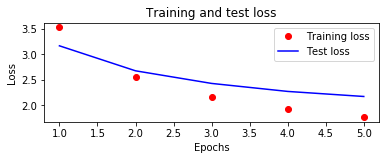

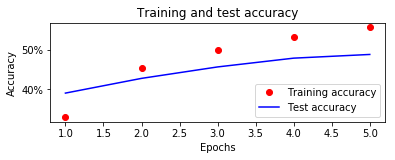

In [45]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']
epochs = range(1, len(val_loss_values) + 1)
import matplotlib.pyplot as plt
%matplotlib inline 

plt.subplot(211)
plt.plot(epochs, history.history['loss'], 'ro', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Test loss')
plt.title('Training and test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()

plt.subplot(212)
plt.plot(epochs, history.history['acc'], 'ro', label='Training accuracy')
plt.plot(epochs, val_acc_values, 'b', label='Test accuracy')
plt.title('Training and test accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.legend()
plt.grid('off')
plt.show()

In [46]:
history_dict

{'acc': [0.32891958392168347,
  0.45406291670799254,
  0.501698445581135,
  0.5331775754627428,
  0.5579338567532991],
 'loss': [3.525574292474044,
  2.564870974249589,
  2.1729253712704306,
  1.9385418144426847,
  1.7687312214801185],
 'val_acc': [0.39061732892990114,
  0.4281549946784973,
  0.45732407546043397,
  0.47969710121154785,
  0.48912393450737],
 'val_loss': [3.166674028015137,
  2.6779187454223634,
  2.4312324047088625,
  2.2748755495071413,
  2.176002446746826]}

In [47]:
encoder_input_data[0]

array([120.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.], dtype=float32)

In [48]:
count = 0
correct_count = 0
pred = model.predict(encoder_input_data[47500:])
for i in range(2500):
  t = np.argmax(pred[i], axis=1)
  act = np.argmax(decoder_target_data[47500],axis=1)
  correct_count += np.sum((act==t) & (act!=89))
  count += np.sum(act!=89)
correct_count/count

0.19653333333333334

In [49]:
decoder_input_data[47500+i]!=89

array([ True,  True,  True,  True,  True,  True, False, False, False,
       False, False, False, False, False, False, False, False])

In [50]:
t

array([127, 320, 320,  63, 142, 142, 142, 142, 142, 142, 142, 142, 142,
       142, 142, 142, 142])

In [51]:
decoder_input_data[47500+i]

array([284.,  86., 320.,  63., 149., 307.,  89.,  89.,  89.,  89.,  89.,
        89.,  89.,  89.,  89.,  89.,  89.], dtype=float32)

In [0]:
encoder_input_data = np.zeros(
    (len(lines.eng), eng_max_length),
    dtype='float32')
decoder_input_data = np.zeros(
    (len(lines.fr), fr_max_length),
    dtype='float32')
decoder_target_data = np.zeros(
    (len(lines.fr), fr_max_length, num_decoder_tokens+1),
    dtype='float32')

for i, (input_text, target_text) in enumerate(zip(lines.eng, lines.fr)):
    for t, word in enumerate(input_text.split()):
        encoder_input_data[i, t] = input_token_index[word]
    for t, word in enumerate(target_text.split()):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t] = target_token_index[word]
        if t>0:          
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
          decoder_target_data[i, t - 1, target_token_index[word]] = 1.
          if t== len(target_text.split())-1:
            decoder_target_data[i, t:, 89] = 1
			
for i in range(decoder_input_data.shape[0]):
  for j in range(decoder_input_data.shape[1]):
    if(decoder_input_data[i][j]==0):
      decoder_input_data[i][j] = 89			

In [53]:
# define NMT model
model2 = Sequential()
model2.add(Embedding(len(input_words)+1, 128, input_length=eng_max_length, mask_zero=True))
model2.add((Bidirectional(LSTM(256))))
model2.add(RepeatVector(fr_max_length))
model2.add((LSTM(256, return_sequences=True)))
model2.add(TimeDistributed(Dense(len(target_token_index)+1, activation='softmax')))
model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 8, 128)            49408     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 512)               788480    
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 17, 512)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 17, 256)           787456    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 17, 359)           92263     
Total params: 1,717,607
Trainable params: 1,717,607
Non-trainable params: 0
_________________________________________________________________


In [54]:
model2.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['acc'])
history1 = model2.fit(encoder_input_data, decoder_target_data,
          batch_size=128,
          epochs=5,
          validation_split=0.05)			

Train on 47500 samples, validate on 2500 samples
Epoch 1/5
47500/47500 [==============================] - 41s 867us/step - loss: 1.2316 - acc: 0.7881 - val_loss: 1.2892 - val_acc: 0.7590
Epoch 2/5
47500/47500 [==============================] - 38s 790us/step - loss: 0.9256 - acc: 0.8141 - val_loss: 1.1580 - val_acc: 0.7685
Epoch 3/5
47500/47500 [==============================] - 38s 795us/step - loss: 0.7755 - acc: 0.8351 - val_loss: 1.0033 - val_acc: 0.7880
Epoch 4/5
47500/47500 [==============================] - 38s 799us/step - loss: 0.6685 - acc: 0.8482 - val_loss: 0.9189 - val_acc: 0.7935
Epoch 5/5
47500/47500 [==============================] - 38s 800us/step - loss: 0.6022 - acc: 0.8565 - val_loss: 0.8694 - val_acc: 0.8009


/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


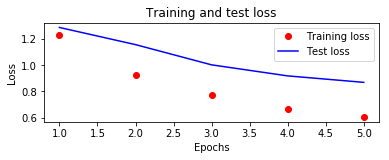

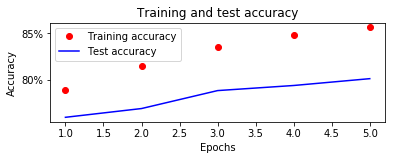

In [55]:
history_dict = history1.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']
epochs = range(1, len(val_loss_values) + 1)
import matplotlib.pyplot as plt
%matplotlib inline 

plt.subplot(211)
plt.plot(epochs, history1.history['loss'], 'ro', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Test loss')
plt.title('Training and test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()

plt.subplot(212)
plt.plot(epochs, history1.history['acc'], 'ro', label='Training accuracy')
plt.plot(epochs, val_acc_values, 'b', label='Test accuracy')
plt.title('Training and test accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.legend()
plt.grid('off')
plt.show()

In [56]:
encoder_input_data.shape

(50000, 8)

In [57]:
count = 0
correct_count = 0
pred = model2.predict(encoder_input_data[47500:])
for i in range(2500):
  t = np.argmax(pred[i], axis=1)
  act = np.argmax(decoder_target_data[47500],axis=1)
  correct_count += np.sum((act==t) & (act!=89))
  count += np.sum(act!=89)
correct_count/count

0.1946

In [58]:
t = model2.predict(encoder_input_data[1].reshape(1,encoder_input_data.shape[1])).reshape(decoder_input_data.shape[1], num_decoder_tokens+1)
t2 = np.argmax(t,axis=1)
for i in range(len(t2)):
  if int(t2[i])!=0:
    print(list(target_token_index.keys())[int(t2[i]-1)])


unk
end
end
end
end
end
end
end
end
end
end
end
end
end
end
end
end


In [59]:
k=48000
t2 = decoder_input_data[k+i]
for i in range(len(t2)):
  if int(t2[i])!=0:
    print(list(target_token_index.keys())[int(t2[i]-1)])

start
je
fais
unk
des
unk
end
end
end
end
end
end
end
end
end
end
end


In [0]:
embedding_size = 128
from keras.layers import Input, LSTM, Embedding, Dense
from keras.models import Model
from keras.utils import plot_model

In [0]:
encoder_inputs = Input(shape=(None,))
en_x=  Embedding(num_encoder_tokens+1, embedding_size)(encoder_inputs)
encoder = LSTM(256, return_state=True)
encoder_outputs, state_h, state_c = encoder(en_x)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

In [0]:
decoder_inputs = Input(shape=(None,))

dex=  Embedding(num_decoder_tokens+1, embedding_size)

final_dex= dex(decoder_inputs)


decoder_lstm = LSTM(256, return_sequences=True, return_state=True)

decoder_outputs, _, _ = decoder_lstm(final_dex,
                                     initial_state=encoder_states)

decoder_outputs = Dense(2000,activation='tanh')(decoder_outputs)

decoder_dense = Dense(num_decoder_tokens+1, activation='softmax')

decoder_outputs = decoder_dense(decoder_outputs)

model3 = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

In [63]:
model3.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, None, 128)    49408       input_1[0][0]                    
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, None, 128)    45952       input_2[0][0]                    
____________________________________________________________________________________________

In [64]:
history3 = model3.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=128,
          epochs=5,
          validation_split=0.05)

Train on 47500 samples, validate on 2500 samples
Epoch 1/5
47500/47500 [==============================] - 27s 573us/step - loss: 1.0415 - acc: 0.8116 - val_loss: 1.0374 - val_acc: 0.7901
Epoch 2/5
47500/47500 [==============================] - 24s 510us/step - loss: 0.6645 - acc: 0.8578 - val_loss: 0.8228 - val_acc: 0.8181
Epoch 3/5
47500/47500 [==============================] - 24s 509us/step - loss: 0.5285 - acc: 0.8751 - val_loss: 0.7105 - val_acc: 0.8299
Epoch 4/5
47500/47500 [==============================] - 24s 508us/step - loss: 0.4483 - acc: 0.8875 - val_loss: 0.6423 - val_acc: 0.8434
Epoch 5/5
47500/47500 [==============================] - 24s 511us/step - loss: 0.3965 - acc: 0.8970 - val_loss: 0.5897 - val_acc: 0.8503


/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


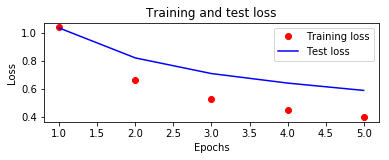

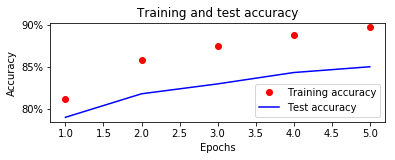

In [65]:
history_dict = history3.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']
epochs = range(1, len(val_loss_values) + 1)
import matplotlib.pyplot as plt
%matplotlib inline 

plt.subplot(211)
plt.plot(epochs, history3.history['loss'], 'ro', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Test loss')
plt.title('Training and test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()

plt.subplot(212)
plt.plot(epochs, history3.history['acc'], 'ro', label='Training accuracy')
plt.plot(epochs, val_acc_values, 'b', label='Test accuracy')
plt.title('Training and test accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.legend()
plt.grid('off')
plt.show()

In [66]:
decoder_target_data.shape

(50000, 17, 359)

In [67]:
act = np.argmax(decoder_target_data, axis=2)
act.shape

(50000, 17)

In [68]:
act[0]

array([321,  89,  89,  89,  89,  89,  89,  89,  89,  89,  89,  89,  89,
        89,  89,  89,  89])

In [69]:
count = 0
correct_count = 0
pred = model3.predict([encoder_input_data[47500:],decoder_input_data[47500:]])
for i in range(2500):
  t = np.argmax(pred[i], axis=1)
  correct_count += np.sum((act[47500+i]==t) & (act[47500+i]!=89))
  count += np.sum(decoder_input_data[47500+i]!=89)
correct_count/count

0.4515258068567123

In [70]:
target_token_index['end']

89

In [0]:
decoder_input_data_pred = np.zeros(
    (len(lines.fr), fr_max_length),
    dtype='float32')

In [0]:
final_pred = []
for i in range(2500):
  if(i%10==0):
    print(i)
  word = 284
  for j in range(17):
    decoder_input_data_pred[(47500+i), j] = word
    pred = model3.predict([encoder_input_data[(47500+i)].reshape(1,8),decoder_input_data_pred[47500+i].reshape(1,17)])
    t = np.argmax(pred[0][j])
    word = t
    if word==89:
      break
  final_pred.append(list(decoder_input_data_pred[47500+i]))

In [73]:
final_pred2 = np.array(final_pred)
final_pred2.shape

(2500, 17)

In [74]:
count = 0
correct_count = 0

for i in range(2500):
  correct_count += np.sum((decoder_input_data[47500+i]==final_pred2[i]) & (decoder_input_data[47500+i]!=89))
  count += np.sum(decoder_input_data[47500+i]!=89)
correct_count/count

0.47488383774959186

In [0]:
# encoder_input_data = np.zeros(
#     (len(lines.eng), eng_max_length),
#     dtype='float32')
# decoder_input_data = np.zeros(
#     (len(lines.fr), fr_max_length),
#     dtype='float32')
# decoder_target_data = np.zeros(
#     (len(lines.fr), fr_max_length, num_decoder_tokens+1),
#     dtype='float32')
	
# for i, (input_text, target_text) in enumerate(zip(lines.eng, lines.fr)):
#     for t, word in enumerate(input_text.split()):
#         encoder_input_data[i, t] = input_token_index[word]
#     for t, word in enumerate(target_text.split()):
#         # decoder_target_data is ahead of decoder_input_data by one timestep
#         decoder_input_data[i, t] = target_token_index[word]
#         if t>0:          
#             # decoder_target_data will be ahead by one timestep
#             # and will not include the start character.
#           decoder_target_data[i, t - 1, target_token_index[word]] = 1.
#           if t== len(target_text.split())-1:
#             decoder_target_data[i, t:, 0] = 1

In [0]:
embedding_size = 128

In [76]:
encoder_inputs = Input(shape=(eng_max_length,))
en_x=  Embedding(num_encoder_tokens+1, embedding_size)(encoder_inputs)
en_x = Dropout(0.1)(en_x)
encoder = LSTM(256, return_sequences=True, unroll=True)(en_x)
encoder_last = encoder[:,-1,:]

print('encoder', encoder)
print('encoder_last', encoder_last)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
encoder Tensor("lstm_7/transpose_1:0", shape=(?, 8, 256), dtype=float32)
encoder_last Tensor("strided_slice:0", shape=(?, 256), dtype=float32)


In [77]:
decoder_inputs = Input(shape=(fr_max_length,))

dex=  Embedding(num_decoder_tokens+1, embedding_size)
#dex = Dropout(0.1)(dex)

decoder= dex(decoder_inputs)
decoder = Dropout(0.1)(decoder)

decoder = LSTM(256, return_sequences=True, unroll=True)(decoder, initial_state=[encoder_last, encoder_last])
print('decoder', decoder)

decoder Tensor("lstm_8/transpose_1:0", shape=(?, 17, 256), dtype=float32)


In [78]:
t = Dense(5000, activation='tanh')(decoder)
#t = Dense(5, activation='tanh')(t)
t

<tf.Tensor 'dense_5/Tanh:0' shape=(?, 17, 5000) dtype=float32>

In [79]:
t2 = Dense(5000, activation='tanh')(encoder)
#t2 = Dense(5, activation='tanh')(t2)
t2

<tf.Tensor 'dense_6/Tanh:0' shape=(?, 8, 5000) dtype=float32>

In [80]:
from keras.layers import Activation, dot, concatenate

attention = dot([t, t2], axes=[2, 2])
attention

<tf.Tensor 'dot_1/MatMul:0' shape=(?, 17, 8) dtype=float32>

In [81]:
# Equation (7) with 'dot' score from Section 3.1 in the paper.
# Note that we reuse Softmax-activation layer instead of writing tensor calculation
# attention = dot([decoder, encoder], axes=[2, 2])
# print(attention)
attention = Dense(eng_max_length, activation='tanh')(attention)
attention = Activation('softmax')(attention)
print('attention', attention)

attention Tensor("activation_1/truediv:0", shape=(?, 17, 8), dtype=float32)


In [82]:
context = dot([attention, encoder], axes = [2,1])
context


<tf.Tensor 'dot_2/MatMul:0' shape=(?, 17, 256) dtype=float32>

In [83]:
decoder_combined_context = concatenate([context, decoder])
print('decoder_combined_context', decoder_combined_context)

decoder_combined_context Tensor("concatenate_1/concat:0", shape=(?, 17, 512), dtype=float32)


In [84]:
output_dict_size = num_decoder_tokens+1
#output = (Dense(100, activation="relu"))(decoder_combined_context)
#output = (Dense(output_dict_size, activation="softmax"))(output)
#decoder_combined_context = Dense(200, activation='tanh')(decoder_combined_context)
#decoder_combined_context = Dense(2000, activation='tanh')(decoder_combined_context)
decoder_combined_context = Dense(2000, activation='tanh')(decoder_combined_context)
output = (Dense(output_dict_size, activation="softmax"))(decoder_combined_context)
print('output', output)

output Tensor("dense_9/truediv:0", shape=(?, 17, 359), dtype=float32)


In [0]:
model4 = Model(inputs=[encoder_inputs, decoder_inputs], outputs=[output])
model4.compile(optimizer='adam', loss='categorical_crossentropy',metrics = ['accuracy'])

In [86]:
model4.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 17)           0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 8)            0                                            
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 17, 128)      45952       input_4[0][0]                    
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 8, 128)       49408       input_3[0][0]                    
____________________________________________________________________________________________

In [87]:
!apt install graphviz
!pip install pydot pydot-ng

Reading package lists... Done
Building dependency tree       
Reading state information... Done
graphviz is already the newest version (2.40.1-2).
0 upgraded, 0 newly installed, 0 to remove and 8 not upgraded.


In [0]:
from keras.utils import plot_model

In [0]:
plot_model(model4, show_shapes=True, show_layer_names=True, to_file='model.png')
from IPython.display import Image

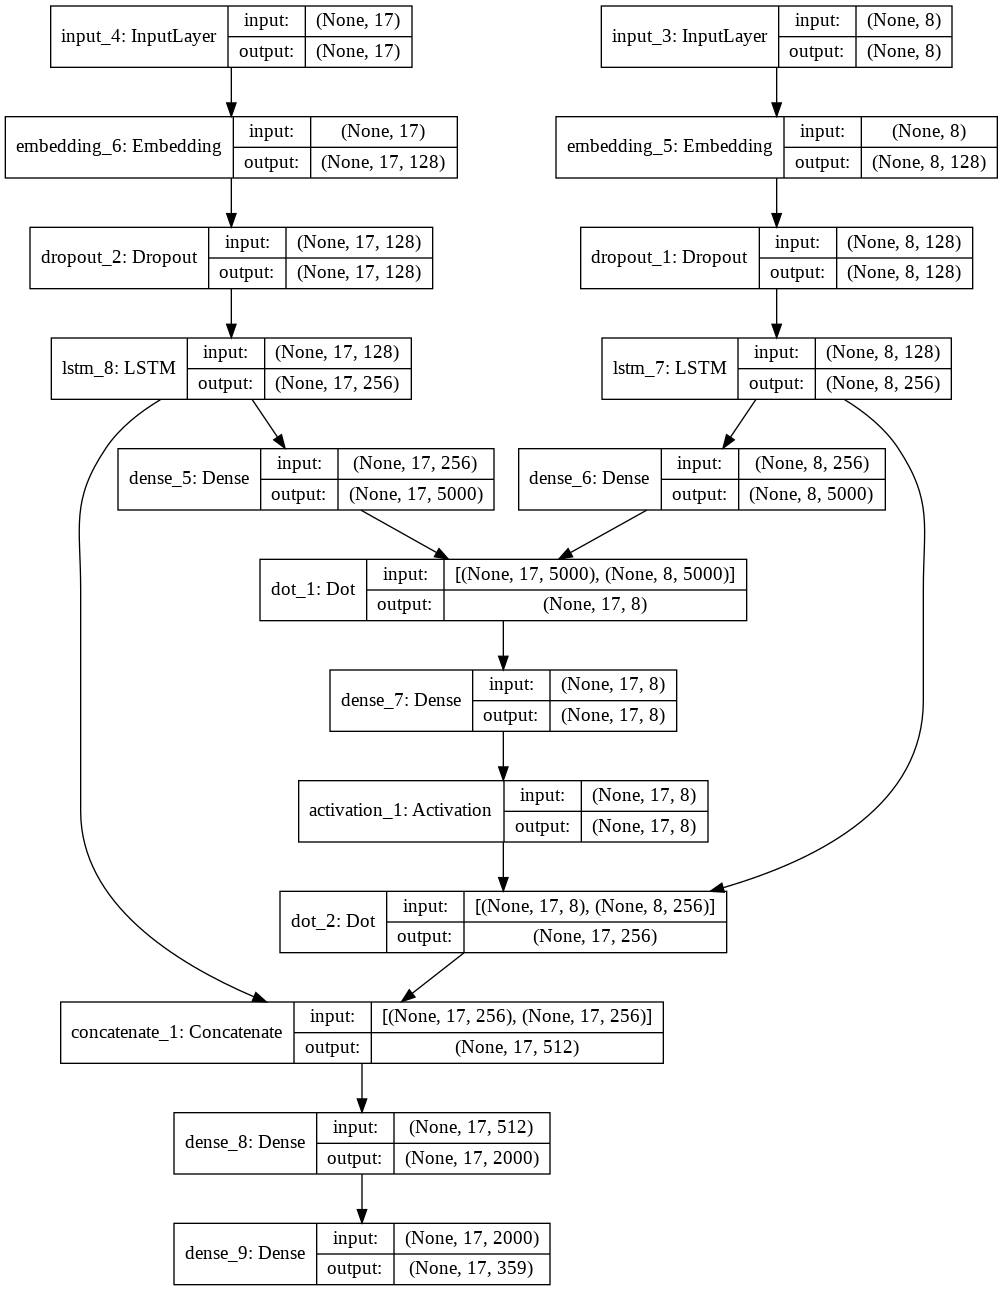

In [90]:
Image(retina=True, filename='model.png')

In [91]:
history4 = model4.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=32,
          epochs=5,
          validation_split=0.05)

Train on 47500 samples, validate on 2500 samples
Epoch 1/5
47500/47500 [==============================] - 94s 2ms/step - loss: 0.7458 - acc: 0.8472 - val_loss: 0.7391 - val_acc: 0.8269
Epoch 2/5
47500/47500 [==============================] - 86s 2ms/step - loss: 0.4569 - acc: 0.8854 - val_loss: 0.6169 - val_acc: 0.8477
Epoch 3/5
47500/47500 [==============================] - 86s 2ms/step - loss: 0.3828 - acc: 0.8993 - val_loss: 0.5625 - val_acc: 0.8567
Epoch 4/5
47500/47500 [==============================] - 86s 2ms/step - loss: 0.3428 - acc: 0.9068 - val_loss: 0.5230 - val_acc: 0.8649
Epoch 5/5
47500/47500 [==============================] - 86s 2ms/step - loss: 0.3179 - acc: 0.9118 - val_loss: 0.5035 - val_acc: 0.8686


/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


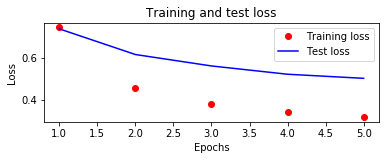

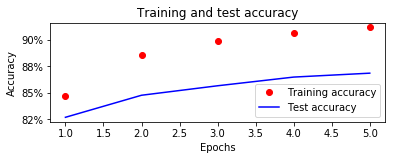

In [92]:
history_dict = history4.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']
epochs = range(1, len(val_loss_values) + 1)
import matplotlib.pyplot as plt
%matplotlib inline 

plt.subplot(211)
plt.plot(epochs, history4.history['loss'], 'ro', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Test loss')
plt.title('Training and test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()

plt.subplot(212)
plt.plot(epochs, history4.history['acc'], 'ro', label='Training accuracy')
plt.plot(epochs, val_acc_values, 'b', label='Test accuracy')
plt.title('Training and test accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.legend()
plt.grid('off')
plt.show()

In [93]:
decoder_input_data_pred = np.zeros(
    (len(lines.fr), fr_max_length),
    dtype='float32')

final_pred_att = []
for i in range(2500):
  if(i%10==0):
    print(i)
  word = 284
  for j in range(17):
    decoder_input_data_pred[(47500+i), j] = word
    pred = model4.predict([encoder_input_data[(47500+i)].reshape(1,8),decoder_input_data_pred[47500+i].reshape(1,17)])
    t = np.argmax(pred[0][j])
    word = t
    if word==89:
      break
  final_pred_att.append(list(decoder_input_data_pred[47500+i]))	

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2100
2110
2120
2130
2140
2150
2160
2170
2180
2190
2200
2210
2

In [94]:
final_pred2_att = np.array(final_pred_att)
count = 0
correct_count = 0

for i in range(2500):
  correct_count += np.sum((decoder_input_data[47500+i]==final_pred2_att[i]) & (decoder_input_data[47500+i]!=89))
  count += np.sum(decoder_input_data[47500+i]!=89)
correct_count/count  

0.5201557202059526

In [0]:
k = -2400

In [0]:
t = model4.predict([encoder_input_data[k].reshape(1,encoder_input_data.shape[1]),decoder_input_data[k].reshape(1,decoder_input_data.shape[1])]).reshape(decoder_input_data.shape[1], num_decoder_tokens+1)

In [97]:
for i in range(len(encoder_input_data[k])):
  if int(encoder_input_data[k][i])!=0:
    print(list(input_token_index.keys())[int(encoder_input_data[k][i]-1)])

i
feel
like
unk


In [98]:
t2 = np.argmax(t,axis=1)
for i in range(len(t2)):
  if int(t2[i])!=0:
    print(list(target_token_index.keys())[int(t2[i]-1)])

jai
unk
unk
unk
des
unk
end
end
end
end
end
end
end
end
end
end
end


In [99]:
t2 = decoder_input_data[k]
for i in range(len(t2)):
  if int(t2[i])!=0:
    print(list(target_token_index.keys())[int(t2[i]-1)])

start
jai
unk
de
faire
la
unk
end
end
end
end
end
end
end
end
end
end
